In [55]:
from omegaconf import DictConfig, OmegaConf

import torch
from torch.nn.functional import conv2d
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from functools import partial

from src import data_loader

cfg = OmegaConf.load("config.yaml")

In [39]:
# ===== Torch config =====
device = cfg.device
torch.manual_seed(cfg.seed)
torch.set_default_dtype(getattr(torch, cfg.tensor_dtype))

# ===== Data Loading =====
train_loader, test_loader = data_loader.get_loader(cfg)

## Sobel Filter Histogram

In [98]:
# Define Sobel filter kernels
sobel_x = (
    torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32)
    .unsqueeze_(0)
    .unsqueeze_(0)
)
sobel_y = (
    torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32)
    .unsqueeze_(0)
    .unsqueeze_(0)
)

In [99]:
grad_cnt_xs = []
grad_cnt_ys = []
for batch_idx, (img_batch, gt_batch) in enumerate(tqdm(train_loader), start=1):
    gt_batch = gt_batch.unsqueeze_(1).to(cfg.device)
    grad_x = conv2d(gt_batch, sobel_x)
    grad_y = conv2d(gt_batch, sobel_y)
    grad_cnt_xs.extend(x.count_nonzero().item() for x in grad_x.flatten(2))
    grad_cnt_ys.extend(y.count_nonzero().item() for y in grad_y.flatten(2))

100%|██████████| 8/8 [00:00<00:00, 11.55it/s]


In [86]:
len(train_loader.dataset)

80

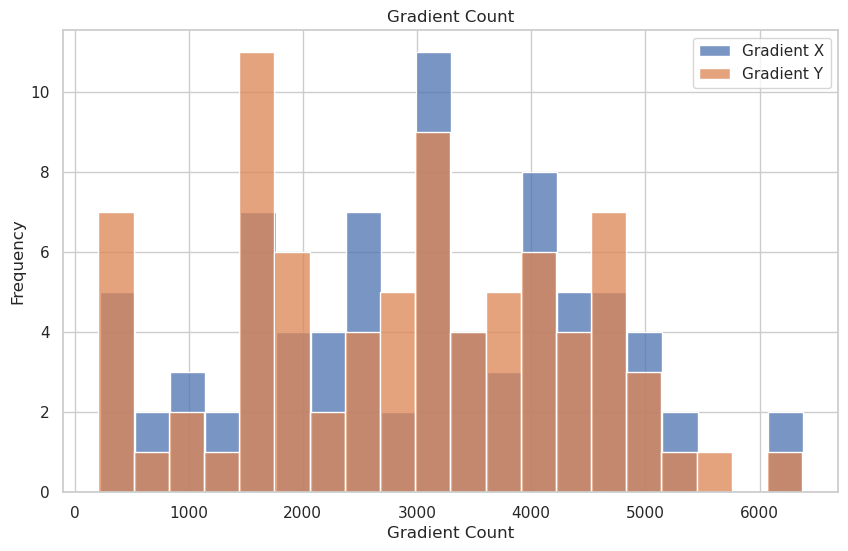

In [100]:
# Plot
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Gradient Count")
ax.set_xlabel("Gradient Count")
ax.set_ylabel("Frequency")
sns.histplot(grad_cnt_xs, ax=ax, label="Gradient X", bins=20)
sns.histplot(grad_cnt_ys, ax=ax, label="Gradient Y", bins=20)
ax.legend()

Text(0.5, 1.0, 'Original Image')

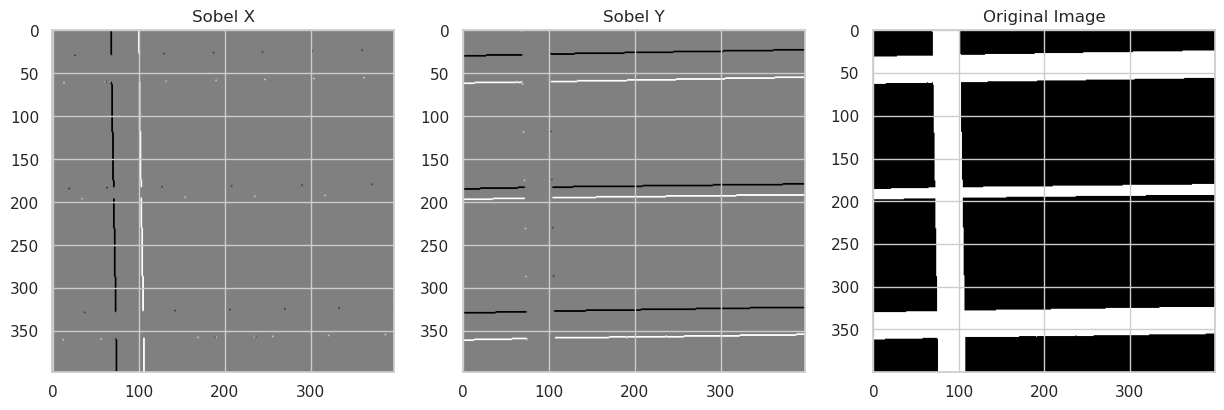

In [97]:
image = 1
gt = gt_batch[image, 0, :, :]
grad_x = grad_x[image, 0, :, :]
grad_y = grad_y[image, 0, :, :]
# Apply Sobel filter using convolution
gt = gt.unsqueeze_(0).unsqueeze_(0)

# Combine gradients to get the magnitude
# gradient_magnitude = torch.sqrt(gradient_x.pow(2) + gradient_y.pow(2))

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(grad_x.squeeze(0).squeeze(0).cpu(), cmap="gray")
ax[0].set_title("Sobel X")
ax[1].imshow(grad_y.squeeze(0).squeeze(0).cpu(), cmap="gray")
ax[1].set_title("Sobel Y")
ax[2].imshow(gt.squeeze(0).squeeze(0).cpu(), cmap="gray")
ax[2].set_title("Original Image")